# CS 109A/AC 209A/STAT 121A Data Science: Homework 8
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 16th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW8.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [14]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Isabelle Mieling

### Part (b): Course Number

CS 109a

### Part (c): Who did you work with?

No one

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Image Processing Revisited

In this problem we revisit applications of classification, with the purpose of comparing the performance of support vector classifiers with other classifiers we have learned. We'll begin with the aeriel vegetation detection problem from Homework #7.

The data is contained in `dataset_1.txt` and `dataset_2.txt` (you are encouraged to use the datasets from Homework #7 as well). The first two columns of the data contains the latitude and longitudes of randomly sampled locations in the satellite image, and the last column contains a label indicating whether the location contains vegetation (1 denotes the presence of vegetation and 0 denotes otherwise). The task is to, again, identify the vegetation regions in the image.

- Compare the result of using support vector classifiers to perform classification against results obtained from other models you have learned. Which model is more appropriate for the general task of vegetation detection in aerial images (do not restrict yourself to which model performs better on just these two datasets)? Which model is more appropriate for other types of image processing (hand-writting digit classification for example) Your comparison should be both **qualitative** and quantitative.

    **Hint:** For your analysis, it's vital to consider the differences between the ways in which each of these models perform classification. These differences can be gauged by looking at the differences between the decision boundaries drawn by the models and **how** these boundaries are determined. 
    
- Are there any obvious draw backs to support vector classifiers as we have presented them to you? What might be some intuitive ways to address these draw backs?

Again, we provide you with a function `plot_decision_boundary` to visualize the decision boundary of a classifier.

In [15]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flag (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white')
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

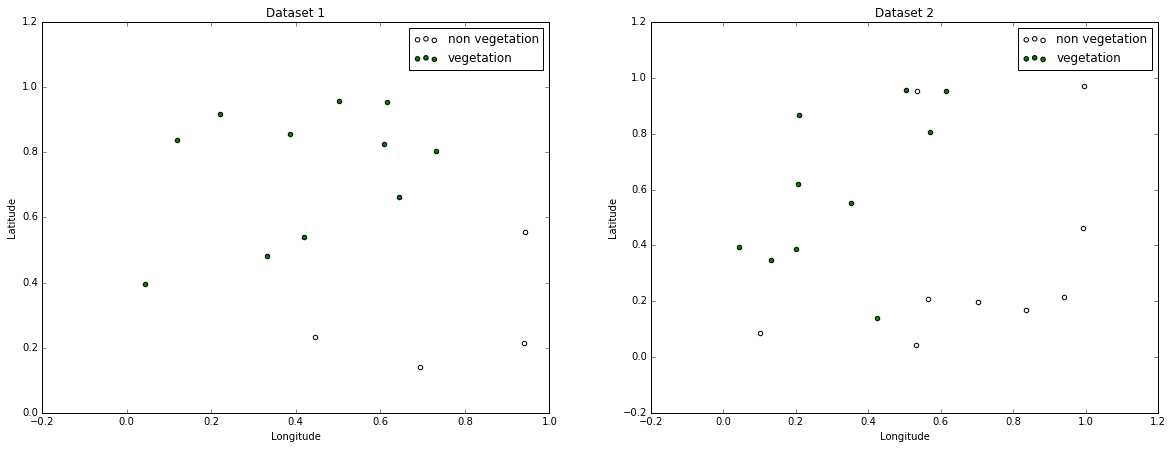

In [16]:
# Since we want to classify vegetation and non-vegetation regions, we should start out by plotting the data so we can visualize the datasets 
# Load dataset 1 
data_1 = pd.read_csv('dataset_1_train.txt', delimiter=',')

# Load dataset 2 
data_2 = pd.read_csv('dataset_2_train.txt', delimiter=',')

# Plot data 
fig, ax = plt.subplots(1,2, figsize = (20, 7))

# Plot dataset 1 

x = data_1.values[:, :-1]
y = data_1.values[:, -1]

ax[0].scatter(x[y==0, 0], x[y==0, 1], c='white', label='non vegetation')
ax[0].scatter(x[y==1, 0], x[y==1, 1], c='green', label='vegetation')

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title('Dataset 1')
ax[0].legend(loc='best')

# Plot dataset 2

x = data_2.values[:, :-1]
y = data_2.values[:, -1]

ax[1].scatter(x[y==0, 0], x[y==0, 1], c='white', label='non vegetation')
ax[1].scatter(x[y==1, 0], x[y==1, 1], c='green', label='vegetation')

ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_title('Dataset 2')
ax[1].legend(loc='best')

plt.show()

** Notes ** : By looking at the plots of the 2 datasets, we see that the regions are well separated in dataset 1 but are not well separated in dataset 2. Dataset 1 sees like it would have a linear boundary but dataset 2 might be more complicated. The vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary respose, and fitting a classification model. The decision boundaries then allow us to identify the vegetation regions. 

## Fit SVM Model with C = 1000, linear kernel

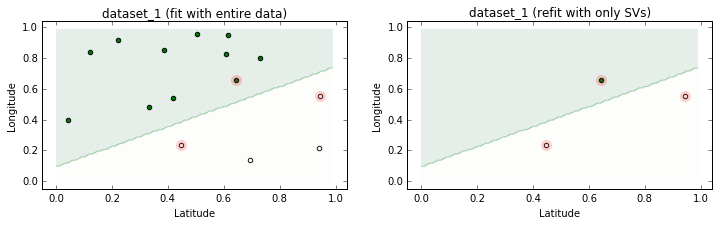

In [17]:
# Load dataset_1
x = data_1.values[:, :-1]
y = data_1.values[:, -1]

# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_1 (fit with entire data)', ax[0])

# Highlight the support vectors
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_1 (refit with only SVs)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

plt.show()

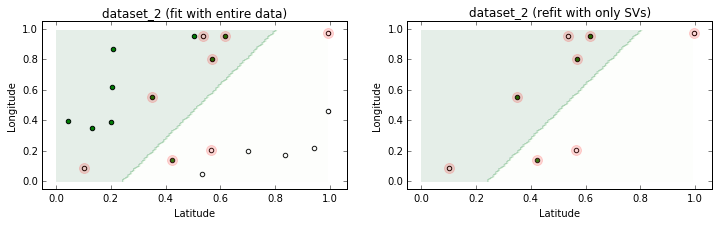

In [18]:
# Load dataset_2
x = data_2.values[:, :-1]
y = data_2.values[:, -1]

# Fit SVM model with C = 1000, linear kernel
model = svm.SVC(C=1000, kernel='linear')
model.fit(x, y)

# Plot decision boundary
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0] = plot_decision_boundary(x, y, model, 'dataset_2 (fit with entire data)', ax[0])

# Highlight the support vectors
sv_indices = model.support_ # retrieve the support vector indices
ax[0].scatter(x[sv_indices, 0], x[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

# Isolate only support vectors and their labels
x_svs = x[sv_indices, :] 
y_svs = y[sv_indices]
model.fit(x_svs, y_svs)

# Plot decision boundary with only support vectors
ax[1] = plot_decision_boundary(x_svs, y_svs, model, 'dataset_2 (refit with only SVs)', ax[1])

# Highlight the support vectors
ax[1].scatter(x_svs[:, 0], x_svs[:, 1], color='red', alpha=0.15, s=100) # draw circles around SVs

plt.show()

** Notes :** We know that the decision boundary of an SVM is determined by a subset of data points, the support vectors. In dataset 1 we see that since the 2 classes are well separated, we can easily find some support vectors that separate the 2 classes. Plotting the decision boundary based solely on these 3 support vectros does shift the decision boundary. SVM chooses the subset of points such that the classes are maximally separated. However, in dataset 2, the classes are less well separated and therefore, the the decision boundary will not be well defined. As we can see from the support vectors, there are some white points in the vegetation area and a green point in the non-vegetation area. 

How might we approach trying to solve this problem? SVM tries to strike a trade-off between the amount of separation between the classes and the accuracy of the model on the training set. Adjusting the parameter C is a means of doing this as C controls this trade-off. In defining our support vector classifier, we need to specify the parameter C and the kernel. A larger C gives more emphasis to accuracy. 

In [19]:
#--------  fit_and_plot_svm_for_c
# Fit and plot SVM model for value of 'C', overlayed on a scatter plot of data 
# (fit on train set and evaluate on test set)
#
# Input: 
#      x_train (array of train predictors)
#      y_train (array of train responses)#      
#      x_test (array of test predictors)
#      y_test (array of test responses)
#      bounds (tuple of bounds for plotting)
#      C  (value for parameter C)
#      ax (axes to plot on)

def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C, ax, bounds=(0, 1)):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    plot_decision_boundary(x_train, y_train, model, \
                           'C = ' + str(C)\
                           + ', train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    sv_indices = model.support_ # retrieve the support vector indices
    ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return ax

## Fit SVM Model with  C = 0.1, 1, 10, 100

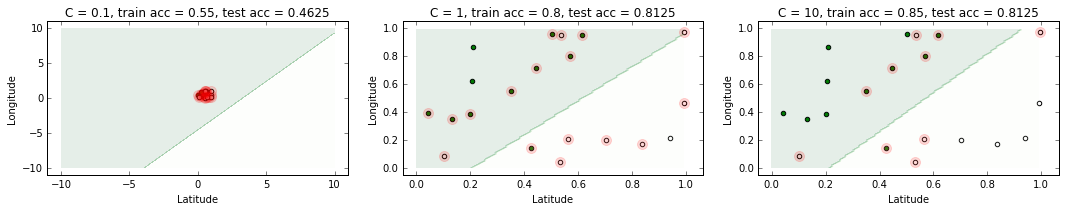

In [20]:
# Load train data
data_train = np.loadtxt("dataset_2_train.txt", delimiter=',')
x_train = data_train[:, 0:-1]
y_train = data_train[:, -1]

# Load test data
data_test = np.loadtxt("dataset_2_test.txt", delimiter=',')
x_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

# Fit and plot for different 'C' values
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 0.1, ax[0], (-10, 10))

ax[1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 1, ax[1])

ax[2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 10, ax[2])

plt.tight_layout()

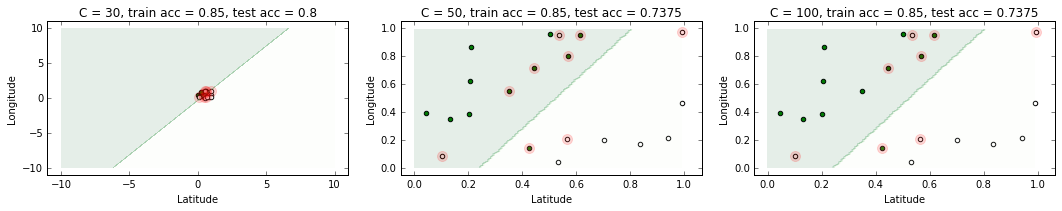

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 30, ax[0], (-10, 10))

ax[1] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 50, ax[1])

ax[2] = fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, 100, ax[2])

plt.tight_layout()

For `dataset_2`, any linear decision boundary would have some errors. In this case, SVM chooses a decision boundary by trading-off the errors for margin (i.e. balancing minimizing error with maximizing margin). It appears that the parameter $C$ controls the trade-off. 

Increasing $C$ lays more emphasis on accuracy and less emphasis on the margin of separation. As a result, the model tends to overfit the train set, and perform poorly on the test set.

For $C=0.01$, the model clearly underfits the train set. For $C=100$, the model overfits the train set. For $C=1$, the fitted model misclassifies a point in the upper left corner (which could have othwerwise been classified correctly by a linear model), and achieves higher margin.

In [31]:
# It looks like the only decision boundaries SVM draws are lines and this is limiting. 
# Let's try to work with the kernel parameter
# specifies the kernel type to be used in the algorithm: either linear, poly, rbf, sigmoid, or precomputed
# let's try SVM with these kernels

## Fit SVM Model with  kernel = linear, poly, rbf, or sigmoid 

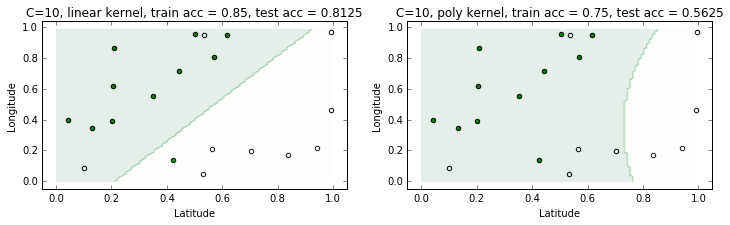

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (12, 3))

## Fit SVM model with C = 10, linear kernel ##
model = svm.SVC(C=10, kernel='linear')
model.fit(x_train, y_train)

# Train and test error
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

# Plot decision boundary
ax[0] = plot_decision_boundary(x_train, y_train, model, 'C=10, linear kernel, train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax[0])   
    
## Fit SVM model with C = 10, poly kernel ##
model = svm.SVC(C=10, kernel='poly')
model.fit(x_train, y_train)

# Train and test error
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

# Plot decision boundary
ax[1] = plot_decision_boundary(x_train, y_train, model, 'C=10, poly kernel, train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax[1])

plt.show()

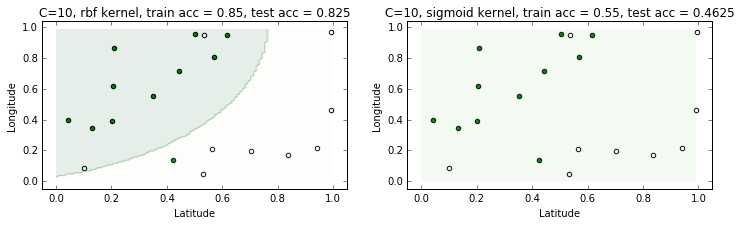

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (12, 3))

## Fit SVM model with C = 10, rbf kernel ##
model = svm.SVC(C=10, kernel='rbf')
model.fit(x_train, y_train)

# Train and test error
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

# Plot decision boundary
ax[0] = plot_decision_boundary(x_train, y_train, model, 'C=10, rbf kernel, train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax[0])   
    
## Fit SVM model with C = 10, sigmoid kernel ##
model = svm.SVC(C=10, kernel='sigmoid')
model.fit(x_train, y_train)

# Train and test error
tr_acc = model.score(x_train, y_train)
ts_acc = model.score(x_test, y_test)

# Plot decision boundary
ax[1] = plot_decision_boundary(x_train, y_train, model, 'C=10, sigmoid kernel, train acc = ' + str(tr_acc)\
                           + ', test acc = ' + str(ts_acc), ax[1])

plt.show()

** Notes ** : Above we experimented with the kernel parameter in the sklearn SVM model. The kernel parameter controls the kernel type the be used in the algorithm and in other words, the type of decision boundary. We get not only a linear decision boundary but a polynomial, sigmoidal, and Gaussian radial basis function boundary. We were able to have curvy boundaries doing this. What this is doing, similar to logistic regression with non-linear boundaries, is creating curvy boundaries in order to maintain the goal of SVM to balance maximum distance between points and accuracy. The model which performs the worst is the sigmoid kernel. The model that performs the best on the training set is a tie between the linear kernel and the rbf kernel, however the radial basis function kernel performs slightly better on the testing set and seems to be more flexible. 

** Next we can try to model the other classifiers we have learned: logistic regression, LDA, QDA, and decision trees.** 

In [24]:
# For additional analysis, we can also consider the 4 datasets from the previous assignment 

sat_img_1 = pd.read_csv('dataset_1.txt', delimiter=',', header=None)
sat_img_2 = pd.read_csv('dataset_2.txt', delimiter=',', header=None)
sat_img_3 = pd.read_csv('dataset_32.txt', delimiter=',', header=None)
sat_img_4 = pd.read_csv('dataset_4.txt', delimiter=',', header=None)

sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]


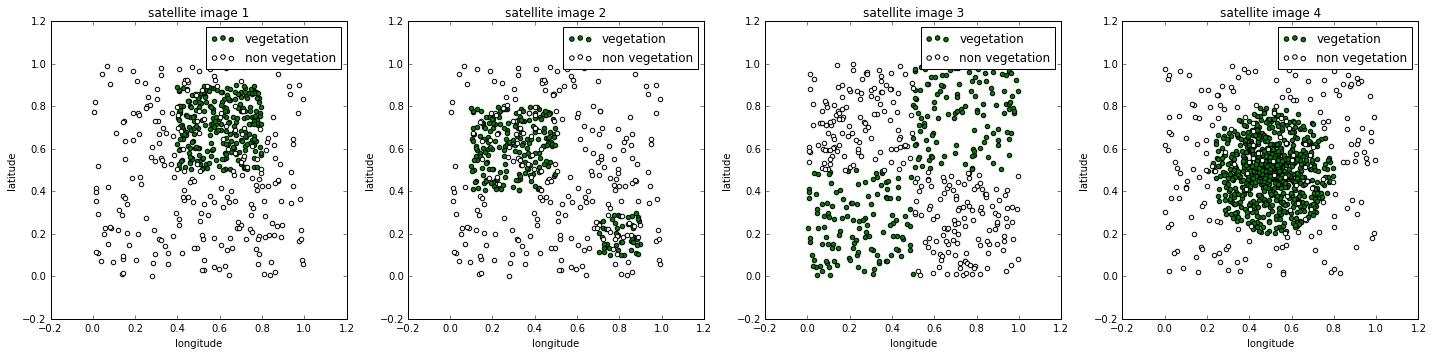

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    x = sat_images[i].values[:, :-1]
    y = sat_images[i].values[:, -1]
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show() 

In [26]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

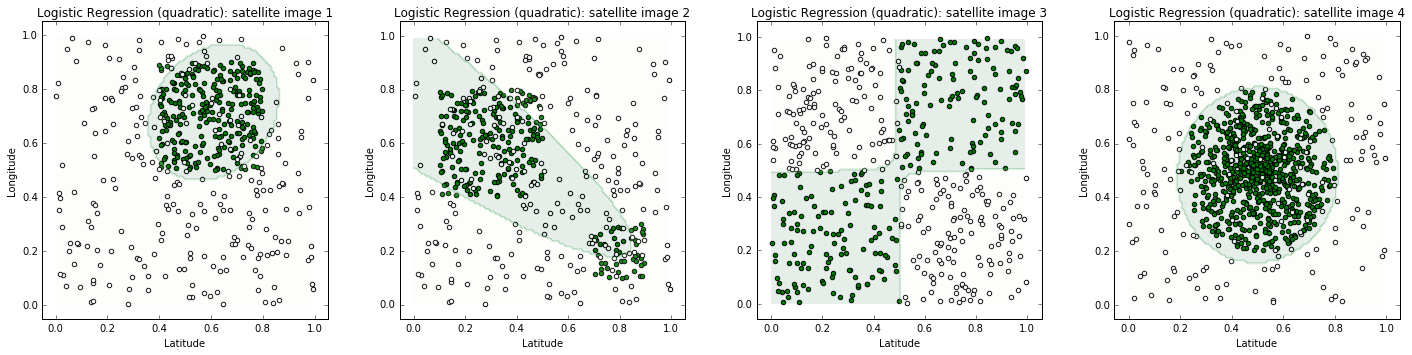

In [27]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

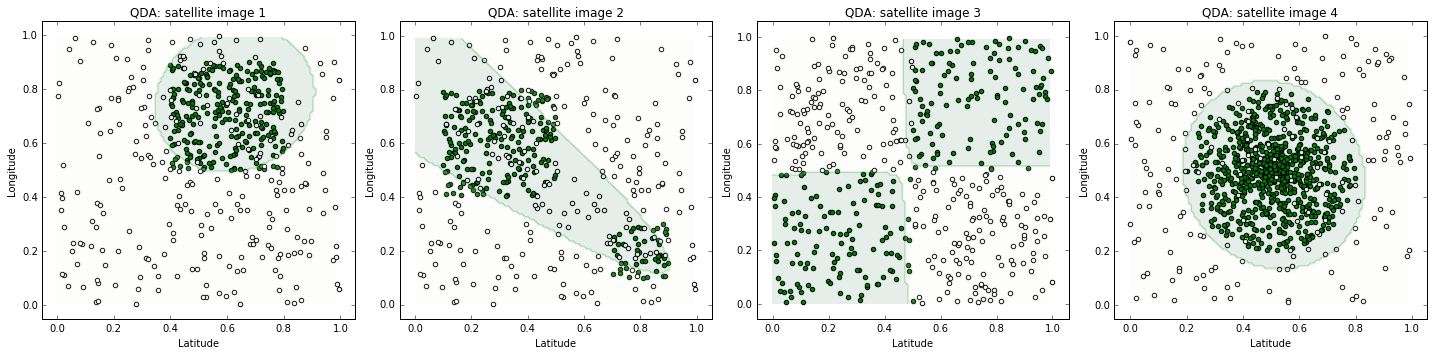

In [28]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#QDA
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()

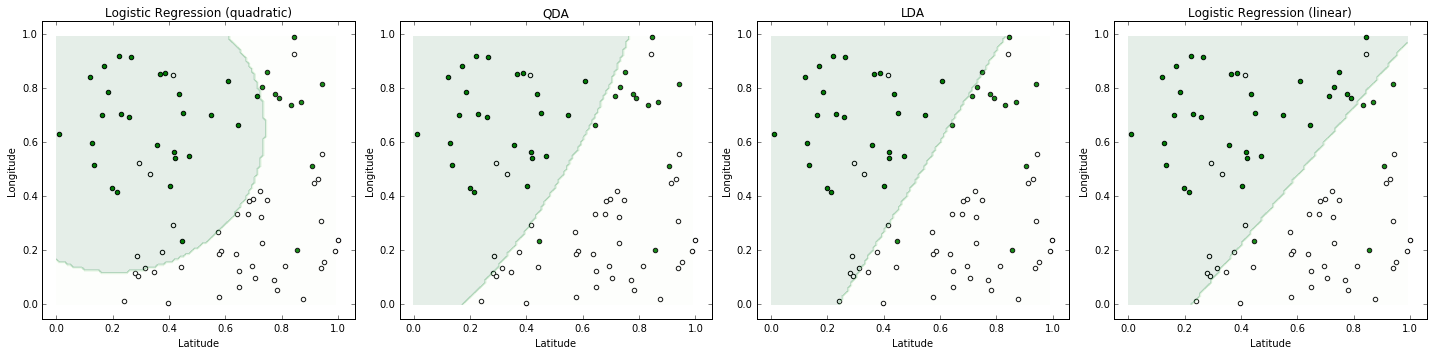

Test accuracy for Logistic Regression:  0.8
Test accuracy for Polynomial Logistic Regression:  0.7875
Test accuracy for LDA:  0.7375
Test accuracy for QDA:  0.775


In [29]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#POLYNOMIAL LOGISTIC REGRESSION
logreg_poly = linear_model.LogisticRegression(C=1000)

# Load train data
data_train = np.loadtxt("dataset_2_train.txt", delimiter=',')
x_train = data_train[:, 0:-1]
y_train = data_train[:, -1]

# Load test data
data_test = np.loadtxt("dataset_2_test.txt", delimiter=',')
x_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_expanded = quad_features.fit_transform(x_train)

#Fit logistic regression model with quadratic decision boundary
logreg_poly.fit(x_expanded, y_train)
    
#Plot the data along with the decision boundary learned by our model
ax[0] = plot_decision_boundary(x_test, y_test, logreg_poly, 'Logistic Regression (quadratic)', ax[0], poly_flag=True)    

# QUADRATIC DISCRIMINANT ANALYSIS
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)
        
ax[1] = plot_decision_boundary(x_test, y_test, qda, 'QDA', ax[1])

#LINEAR DISCRIMINANT ANALYSIS

lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
    
ax[2] = plot_decision_boundary(x_test, y_test, lda, 'LDA', ax[2])

## LOGISTIC REGRESSION

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()
logreg.fit(x_train, y_train)

ax[3] = plot_decision_boundary(x_test, y_test, logreg, 
                                   'Logistic Regression (linear)', ax[3])
plt.tight_layout()
plt.show()

ts_acc = logreg.score(x_test, y_test)
print "Test accuracy for Logistic Regression: ", ts_acc
x_expanded = quad_features.fit_transform(x_test)
ts_acc = logreg_poly.score(x_expanded, y_test)
print "Test accuracy for Polynomial Logistic Regression: ", ts_acc
ts_acc = lda.score(x_test, y_test)
print "Test accuracy for LDA: ", ts_acc
ts_acc = qda.score(x_test, y_test)
print "Test accuracy for QDA: ", ts_acc


In [30]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    fit = dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax, fit 

Accuracy on the test set, depth  1  is:  0.6625
Accuracy on the test set, depth  2  is:  0.7
Accuracy on the test set, depth  3  is:  0.825
Accuracy on the test set, depth  4  is:  0.825
Accuracy on the test set, depth  5  is:  0.825


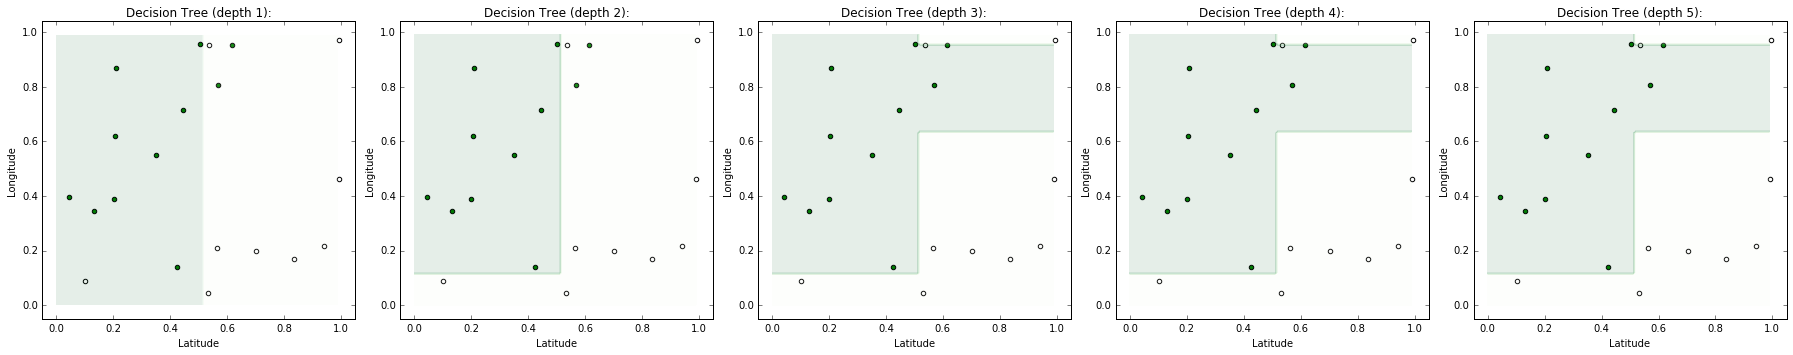

In [31]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind], fit1 = fit_and_plot_dt(x_train, y_train, i, 'Decision Tree (depth {}):'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1
    test_score = fit1.score(x_test, y_test)
    print "Accuracy on the test set, depth ", i, " is: " , test_score

plt.tight_layout()
plt.show()

** Comparing SVM with other classifiers** From these results above we can see that the classifiers we have at our disposal all work quite well, all above 73% accuracy in the testing set. The decision tree model with depths 3-5 perform the best with accuracy of 83%. Linear Logistic Regression performs well with 80% accuracy on the testing set with Polynomial Logistic Regression, LDA, and QDA following close behind around 75% accuracy. This is interesting because we get similar accuracy for SVM, as shown above. We had a test accuracy of 81% when using C=1 and C=10 for a linear kernel. This is comparative to the 80% accuracy from linear logistic regression as these have similar approaches. We see 82% accuracy for C=10 with a rbf kernel.

** Drawbacks to support vector classifiers: ** 
The fact that we have to choose a kernel for a support vector classifier is a drawback of this method. We might remedy this drawback by selected the most flexible kernel relating to the question we are trying to answer. For example, for the general task of vegetation detection in aerial images, we may choose to use the rbf kernel as it is more flexible and would be able to detect the various different shapes of vegetation as we have seen in dataset_1, dataset_2, and the 4 datasets from HW 7, as plotted in this homework. Another drawback is that we may overfit the model. This can be managed by selecting a C value which will account for the tradeoff between accuracy and minimum distance, therefore reduce some of the chance for overfitting on the training set. 


** Which model is most appropriate for the general task of vegetation detection in aerial images? ** As we have seen in this homework (dataset_1, dataset_2) and the previous homework (4 satelite images), there are many shapes in which vegetation can come in. The ideal classifier should be able to detect all shapes and adjust properly to differnt clusters of data points. Therefore, it would be unwise to choose any classifier which would give a linear boundary as we cannot be certain that the classes will be separated with a natural linear boundary. More likely, the natural separations will be curved and will require a more flexible classifier able to detect and distinguish between the 2 classes. Therefore, I would recommend using polynomial logistic regression, QDA, or SVM. This recommendation would also work for other times of image processing where the boundaries may not be linear. However, SVM may be the best model to select since it has flexibility in which kernel you choose and the value of C, though having these parameters to estimate is also a drawback. We also see above that decision trees perform quite well and have high accuracy after a few split. I would not recommen decision trees for this particular purpose because the split points would not have any significance and therefore there would be no interpretation from the splits and the results would be overly convoluted. Overall SVM is a strong match compared to previous classifiers we have worked with.    

## Problem 2 (Optional): Classification Competition

This problem will involve an class-wide model building competition, where you will compete with each other in building a prediction model for cancer diagnosis. The results will be displayed live on a public leaderboard. The competition begins on Nov 9th, 3:00pm, and end on Nov 16th, 11:59pm. 

Please access the following link for all relevant details (data set, submission instructions, evaluation metric, leader board, etc.):
https://inclass.kaggle.com/c/harvard-data-science-course-competition

**Reward:** The top 20% of students on the leaderboard will each receive one bonus point to apply to an homework score of their choice (meaning you can turn a homework score of 2 to a 3, 3 to a 4, 5 to a 6 etc).

---

## Challenge Problem: Meta Learning

In the problem, you are provided with 10 different previously trained prediction models for a spam classification task. The task is to investigate how can one combine these models into a single meta classification model (without retraining the individual models) that performs better than each of the individual ones? 

The data for this problem is provided in the files `dataset_5_train.txt` and `dataset_5_test.txt`. Each row of these files is an email described by 57 attributes, and the last column is 1 if the email is spam, and 0 otherwise. 

The prediction models are provided in the file `models.npy` and can be loaded into an array by executing: 

`models = np.load('models.npy')`

As before, you can make predictions using the $i^\text{th}$ using:

`model[i].predict(x_test)` 

and score the model using:

`model[i].score(x_test, y_test)`

The baseline for this task is a simple combination strategy that takes a majority vote from the individual prediction models.

**Any reasonable model that performs better than the baseline model on the test set will receive full credit.**

There are many intuitive ways to combine these 10 models into one; a more sophisticated approach is called "mixture of experts". In this problem, we are not requiring you to implement any particular approach.

---